In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch

import matplotlib as mpl
cmap=mpl.colormaps["tab10"]
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

from plotting import plot_input_space, plot_pareto_box, plot_pareto_space, AngleAnnotation

tkwargs = {"dtype": torch.double, "device": torch.device("cpu"),}

In [3]:
# define problem
problem = GMM(negate=True).to(**tkwargs)
problem.ref_point = torch.tensor([0., 0.], **tkwargs)

In [4]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [5]:
init_x, init_y = generate_initial_data(problem, n=60)

x_obs, y_obs = init_x, init_y

num_samples = 100
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], num_samples
    ),
    np.linspace(
        *problem.bounds.t()[1], num_samples
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data)
output_data = problem(input_data)

## Problem

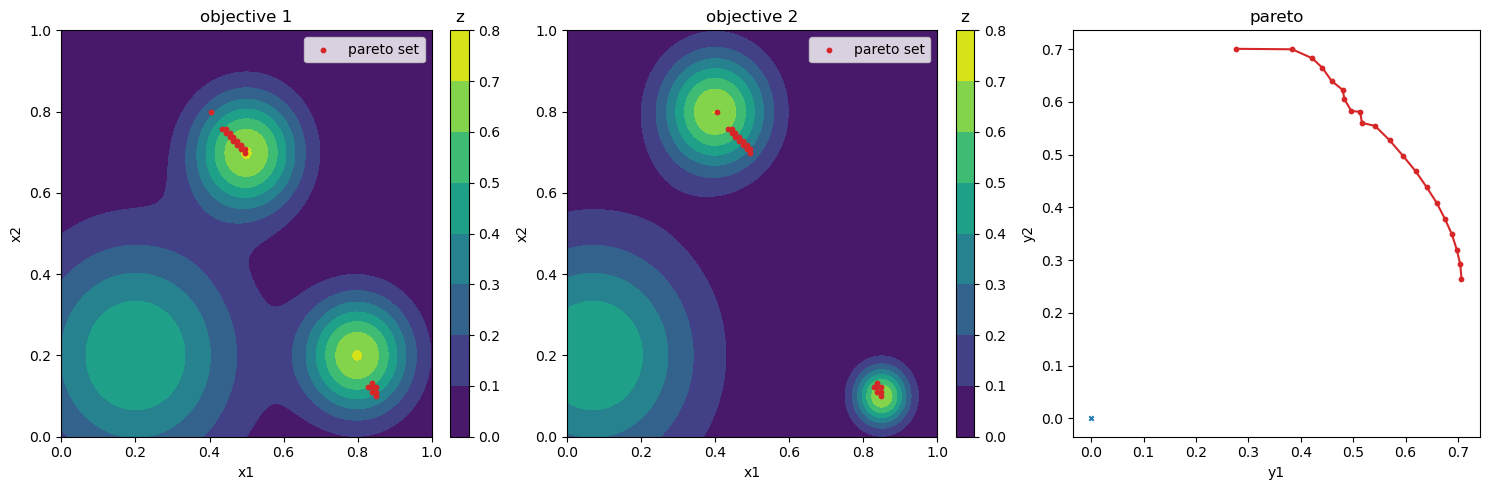

In [6]:
n_objs = problem.num_objectives

fig = plt.figure(figsize=(15, 5))

pareto = is_non_dominated(output_data)
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=output_data)

u, l = bd.hypercell_bounds

for i in range(n_objs):
    ax = plt.subplot2grid((1, n_objs + 1), (0, i))
    plot_input_space(xx, yy, output_data[:, i], fig, ax)
    ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')
    ax.set_title(f"objective {i + 1}")
    ax.legend()

ax_pareto = plt.subplot2grid((1, n_objs + 1), (0, n_objs))
plot_pareto_space(output_data, pareto, ref_point=problem.ref_point, l=l, u_nbd=None, ax=ax_pareto)
plt.tight_layout()

In [7]:
# To polar coordinates
def cart2pol(x, y):
    rho = torch.sqrt(x**2 + y**2)
    phi = torch.arctan2(x, y)
    return (rho.reshape(-1, 1), phi.reshape(-1, 1))

def pol2cart(rho, phi):
    x = rho * torch.cos(phi)
    y = rho * torch.sin(phi)
    return (x, y)


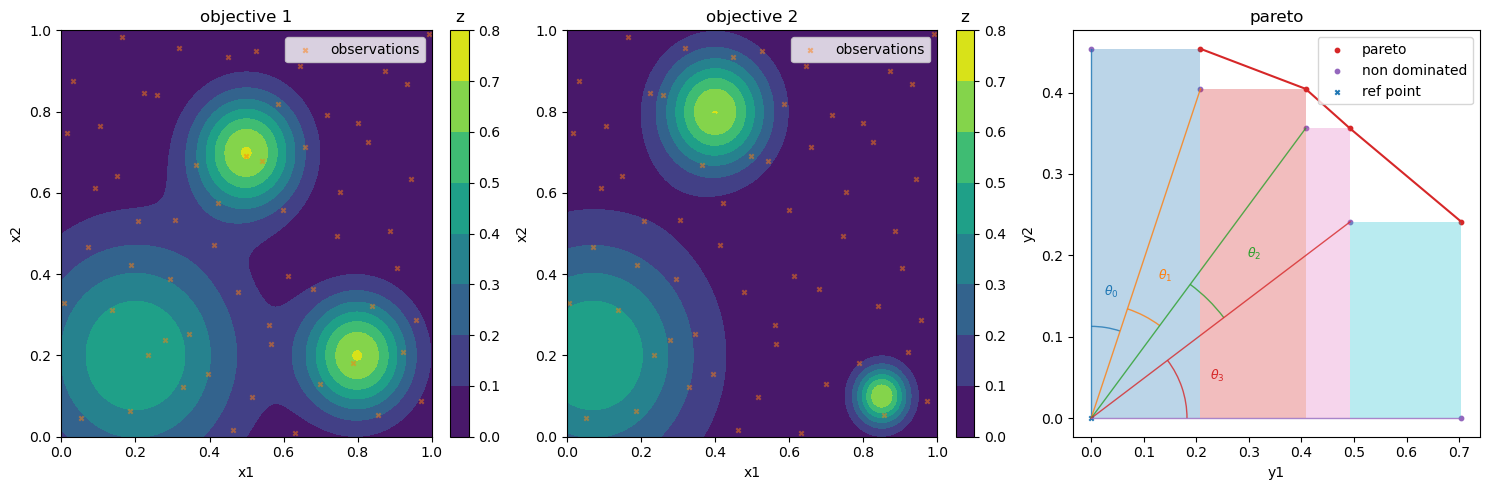

In [45]:
fig = plt.figure(figsize=(15, 5))

pareto = is_non_dominated(y_obs)
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

u, l = bd.hypercell_bounds
u_nbd, _ = nbd.hypercell_bounds

boxes = [Rectangle(
    l_point.cpu(),
    *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)
]

for i in range(n_objs):
    ax = plt.subplot2grid((1, n_objs + 1), (0, i))
    plot_input_space(xx, yy, output_data[:, i], fig, ax)
    ax.scatter(*x_obs.t(), alpha=0.5, s=10, color='tab:orange', marker='x', label='observations')
    ax.set_title(f"objective {i + 1}")
    ax.legend()

ax_pareto = plt.subplot2grid((1, n_objs + 1), (0, n_objs))
plot_pareto_space(y_obs, pareto, problem.ref_point, l, u_nbd, ax_pareto, title='pareto')
plot_pareto_box(boxes, ax_pareto)
ax_pareto.legend()

for n, pt in enumerate(u_nbd):
    line = Line2D(
        [problem.ref_point[0], pt[0]],
        [problem.ref_point[1], pt[1]],
        linewidth=1, linestyle = "-",
        color=cmap(n),
        alpha=.8
    )
    ax_pareto.add_line(line)
    if n < len(u_nbd) - 1:
        rho1, phi1 = cart2pol(u_nbd[n, 1], u_nbd[n, 0])
        rho2, phi2 = cart2pol(u_nbd[n+1, 1], u_nbd[n+1, 0])
        angle = (phi1 - phi2) * 180 / torch.pi
        am = AngleAnnotation(
                problem.ref_point,
                u_nbd[n+1],
                u_nbd[n],
                ax=ax_pareto, 
                size=5000/angle.item(),
                text=rf"$\theta_{n}$",
                textposition = "edge",
                text_kw=dict(fontsize=9, color=cmap(n)),
                color=cmap(n),
                alpha=.8
            )

plt.tight_layout()

## Generate training data

In [68]:
rhos, phis = cart2pol(y_obs[:, 1], y_obs[:, 0])

pareto = is_non_dominated(y_obs)
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

u, l = bd.hypercell_bounds
u_nbd, _ = nbd.hypercell_bounds

x_train = torch.empty(0, problem.dim)
y_train = torch.empty(0, problem.num_objectives)
angles = torch.empty(0, 1)

for n in range(len(u_nbd) - 1):
    rho1, phi1 = cart2pol(u_nbd[n, 1], u_nbd[n, 0])
    rho2, phi2 = cart2pol(u_nbd[n+1, 1], u_nbd[n+1, 0])

    idx = torch.logical_and(phi2 <= phis, phis <= phi1).squeeze()

    x_train = torch.concat([x_train, x_obs[idx]], dim=0)
    y_train = torch.concat([y_train, y_obs[idx]], dim=0)
    angles = torch.concat([angles, torch.empty(len(x_obs[idx]), 1).fill_(n)], dim=0)

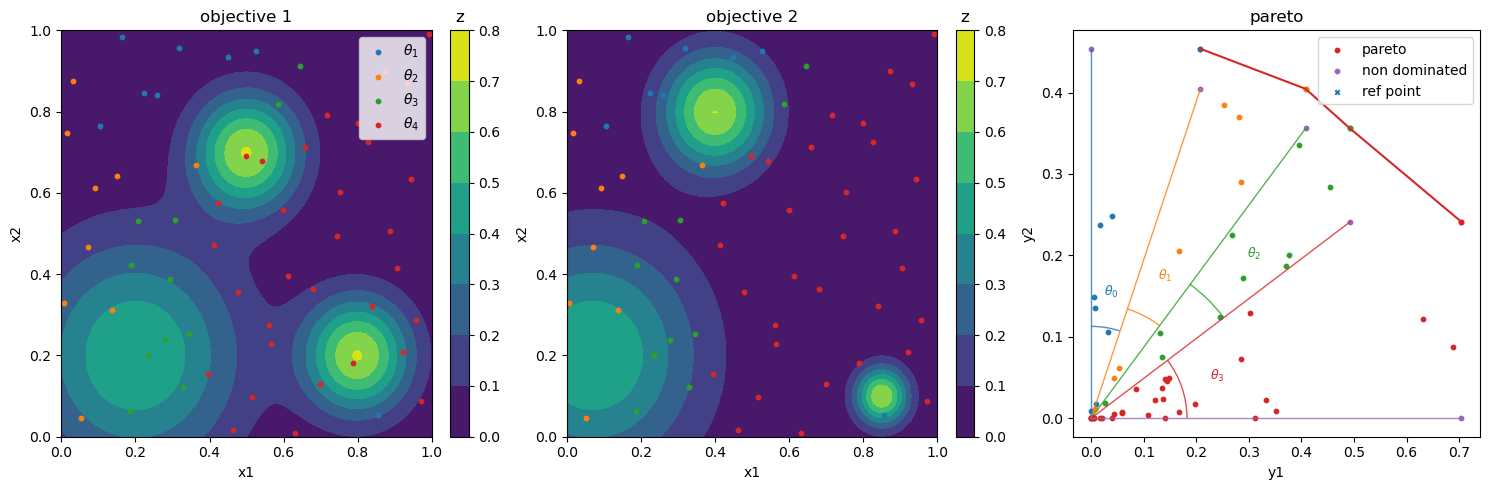

In [90]:
fig = plt.figure(figsize=(15, 5))

boxes = [Rectangle(
    l_point.cpu(),
    *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)
]

axs = []
for i in range(n_objs):
    ax = plt.subplot2grid((1, n_objs + 1), (0, i))
    plot_input_space(xx, yy, output_data[:, i], fig, ax)
    ax.set_title(f"objective {i + 1}")
    axs.append(ax)

ax_pareto = plt.subplot2grid((1, n_objs + 1), (0, n_objs))
plot_pareto_space(y_obs, pareto, problem.ref_point, l, u_nbd, ax_pareto, title='pareto')
# plot_pareto_box(boxes, ax_pareto)
ax_pareto.legend()

for n, pt in enumerate(u_nbd):
    line = Line2D(
        [problem.ref_point[0], pt[0]],
        [problem.ref_point[1], pt[1]],
        linewidth=1, linestyle = "-",
        color=cmap(n),
        alpha=0.8,
    )
    ax_pareto.add_line(line)
    if n < len(u_nbd) - 1:
        rho1, phi1 = cart2pol(u_nbd[n, 1], u_nbd[n, 0])
        rho2, phi2 = cart2pol(u_nbd[n+1, 1], u_nbd[n+1, 0])
        angle = (phi1 - phi2) * 180 / torch.pi
        am = AngleAnnotation(
                problem.ref_point,
                u_nbd[n+1],
                u_nbd[n],
                ax=ax_pareto, 
                size=5000/angle.item(),
                text=rf"$\theta_{n}$",
                textposition = "edge",
                text_kw=dict(fontsize=9, color=cmap(n)),
                color=cmap(n),
                alpha=.8
            )

        idx = torch.logical_and(phi2 <= phis, phis <= phi1).squeeze()
        xs = x_obs[idx]
        ys = y_obs[idx]
        axs[0].scatter(xs[:, 0], xs[:, 1], s=10, color=cmap(n), label=rf"$\theta_{n+1}$")
        axs[1].scatter(xs[:, 0], xs[:, 1], s=10, color=cmap(n))
        axs[0].legend()
        ax_pareto.scatter(ys[:, 0], ys[:, 1], s=10, color=cmap(n))

plt.tight_layout()

In [95]:
class MLP(torch.nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        device="cpu:0",
        dtype=torch.double,
    ) -> None:
        super().__init__()
        self.tkwargs = {"device": device, "dtype": dtype}

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, output_dim),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [101]:
angles_class = torch.nn.functional.one_hot(angles.squeeze().long(), num_classes=len(u_nbd) - 1).to(**tkwargs)
model = MLP(input_dim=2, output_dim=len(u_nbd) - 1)
model.to(**tkwargs)

optimizer = torch.optim.AdamW(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

# add batch dimension
train_tensors = [x_train, angles_class]
train_dataset = torch.utils.data.TensorDataset(*train_tensors)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

model.train()
for epochs in range(1000):
    for _, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = loss_fn(outputs, targets)
        batch_loss.backward()
        optimizer.step()
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
)

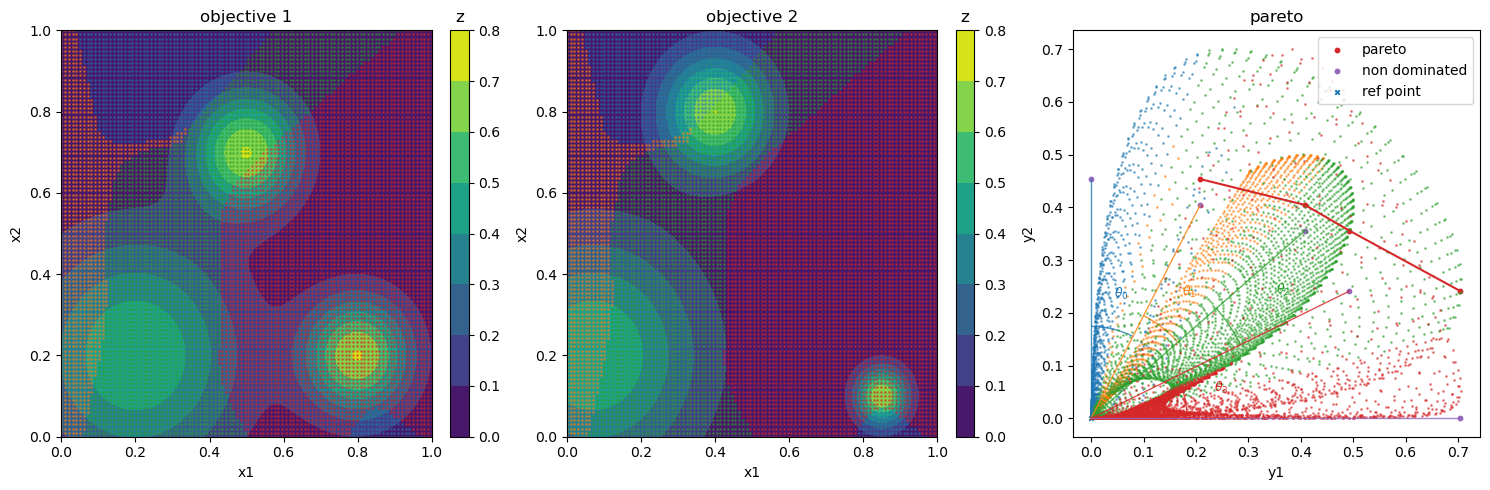

In [122]:
fig = plt.figure(figsize=(15, 5))

boxes = [Rectangle(
    l_point.cpu(),
    *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)
]

axs = []
for i in range(n_objs):
    ax = plt.subplot2grid((1, n_objs + 1), (0, i))
    plot_input_space(xx, yy, output_data[:, i], fig, ax)
    ax.set_title(f"objective {i + 1}")
    axs.append(ax)

ax_pareto = plt.subplot2grid((1, n_objs + 1), (0, n_objs))
plot_pareto_space(y_obs, pareto, problem.ref_point, l, u_nbd, ax_pareto, title='pareto')
# plot_pareto_box(boxes, ax_pareto)
ax_pareto.legend()

for n, pt in enumerate(u_nbd):
    line = Line2D(
        [problem.ref_point[0], pt[0]],
        [problem.ref_point[1], pt[1]],
        linewidth=1, linestyle = "-",
        color=cmap(n),
        alpha=0.8,
    )
    ax_pareto.add_line(line)
    if n < len(u_nbd) - 1:
        rho1, phi1 = cart2pol(u_nbd[n, 1], u_nbd[n, 0])
        rho2, phi2 = cart2pol(u_nbd[n+1, 1], u_nbd[n+1, 0])
        angle = (phi1 - phi2) * 180 / torch.pi
        am = AngleAnnotation(
                problem.ref_point,
                u_nbd[n+1],
                u_nbd[n],
                ax=ax_pareto, 
                size=5000/angle.item(),
                text=rf"$\theta_{n}$",
                textposition = "edge",
                text_kw=dict(fontsize=9, color=cmap(n)),
                color=cmap(n),
                alpha=.8
            )

with torch.no_grad():
    predictions = model(input_data) 
pred_cls = torch.nn.functional.softmax(predictions, dim=0)
pred_cls = pred_cls.argmax(dim=1)
for i in range(4):
    idx = pred_cls == i
    axs[0].scatter(input_data[idx][:, 0], input_data[idx][:, 1], s=1, color=cmap(i), alpha=.5)
    axs[1].scatter(input_data[idx][:, 0], input_data[idx][:, 1], s=1, color=cmap(i), alpha=.5)
    ax_pareto.scatter(output_data[idx][:, 0], output_data[idx][:, 1], s=1, color=cmap(i), alpha=.5)

plt.tight_layout()